In [1]:
# standard libraries
import numpy as np
import pandas as pd
import re

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [13, 10]

In [2]:
#NLTK
from nltk.stem.wordnet import WordNetLemmatizer
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
tokenizer = ToktokTokenizer()
stopword_list = stopwords.words('english')


In [3]:
#Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#Feature extraction
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Algorithms
from sklearn import linear_model 
from sklearn import tree  
from sklearn.svm import SVC  
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB  
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

C:\Users\Dominic Soon\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
import os
os.getcwd()

'C:\\Users\\Dominic Soon\\Stock predictor'

In [5]:
data = pd.read_csv('Combined_News_DJIA.csv')

In [6]:
data.head()


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

## Simple EDA

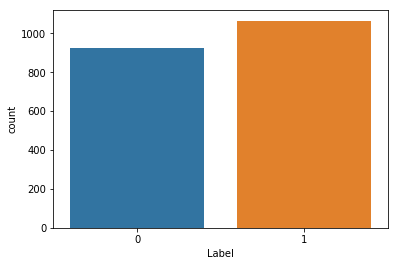

In [7]:
sns.countplot(x=data['Label'].dropna(),data=data)

**1 if the DJIA stayed the same or rose on that date** or **0** if the DJIA **fell on that date.** <br>
Looks like there were more up days than down days.

## Pre-processing / Countvectorizer

In [8]:
# train/test split by date
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']
print(f'Shapes of train: {train.shape} and test: {test.shape}')

Shapes of train: (1611, 27) and test: (378, 27)


In [9]:
# run text pre-processing

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    lmtzr = WordNetLemmatizer()
    text = text.split(' ')
    text = [lmtzr.lemmatize(word) for word in text]
    preprocessed_text= ' '.join(text)
    return preprocessed_text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def remove_short_words(text):
    return ' '.join([x for x in text.split() if len(x)>3])

def remove_first_b(text):
    pattern = r'^b'
    text = re.sub(pattern, '',text)
    return text



In [10]:
def normalize_corpus(corpus,accented_char_removal=True, text_lower_case=True, short_words_removal=True,
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=False):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)            
        # remove words len < 4
        if short_words_removal:
            doc = remove_short_words(doc)
        # remove special characters and\or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        # remove first b in every headline
        normalized_corpus.append(str(doc))
        
    return normalized_corpus

testcorpuslist = normalize_corpus(["y'all @RT I'll are dogs and then on a home faces doing millennia !@#h$ 124 geese"])

In [11]:
# joining train and test headlines into list and remove the first b

trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(remove_first_b(str(x)) for x in train.iloc[row,2:27]))
    
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(remove_first_b(str(x)) for x in test.iloc[row,2:27]))


In [12]:
print(f'Length of train headlines: {len(trainheadlines)} and test headlines: {len(testheadlines)}')

Length of train headlines: 1611 and test headlines: 378


In [13]:
# running headlines thru the NLTK
clean_trainheadlines = normalize_corpus(trainheadlines)
clean_trainheadlines = [remove_short_words(i) for i in clean_trainheadlines] #passing short words adter taking out special char

clean_testheadlines = normalize_corpus(testheadlines)
clean_testheadlines = [remove_short_words(i) for i in clean_testheadlines] #passing short words adter taking out special char


In [14]:
# Preprocessing data using countvectorizer 

# select n-grams
ngram = (1,1)

count_vectorizer = CountVectorizer(ngram_range=ngram)
count_train = count_vectorizer.fit_transform(clean_trainheadlines)
count_test = count_vectorizer.transform(clean_testheadlines)
feature_names = count_vectorizer.get_feature_names()
print(count_train.shape)

(1611, 32577)


In [15]:
# Standardise the terms

X_train = count_train
y_train = train['Label']

X_test = count_test
y_test = test['Label']

## Testing the models <br>
### Logistic Regression

In [16]:
# Logistic Regression

lm_clf = LogisticRegression(random_state=1)
lm_clf.fit(X_train, y_train) #this is where we are training the model to fit LogisticRegression

y_pred = lm_clf.predict(X_test)

In [17]:
lm_acc_score = accuracy_score(y_test, y_pred)
lm_f1 = f1_score(y_test, y_pred)
lm_confusion_m = confusion_matrix(y_test, y_pred)
lm_recall = recall_score(y_test, y_pred)
lm_precision = precision_score(y_test, y_pred)

print(f'Total accuracy classification score: {round(lm_acc_score,4)}')
print(f'Total F1 classification score: {round(lm_f1,4)}')
print(f'Confusion matrix: {lm_confusion_m}')
print(f'Recall: {round(lm_recall,4)}')
print(f'Precision: {round(lm_precision,4)}')

Total accuracy classification score: 0.4921
Total F1 classification score: 0.545
Confusion matrix: [[ 71 115]
 [ 77 115]]
Recall: 0.599
Precision: 0.5


In [18]:
lm_coeffs = lm_clf.coef_ .tolist()[0] #get a list of len 
lm_coeffdf = pd.DataFrame({'Word' : feature_names, 
                        'Coefficient' : lm_coeffs})
lm_coeffdf = lm_coeffdf.sort_values(['Coefficient', 'Word'], ascending=False)
lm_coeffdf.iloc[np.r_[0:4, -4:0]]

,Word,Coefficient
28995,television,0.505445
19957,nigeria,0.501220
25817,scrap,0.479064
27270,someone,0.457209
28997,tell,-0.503282
23846,real,-0.512465
14324,hour,-0.531619
13325,hacking,-0.540343


### SGD Classifier

In [19]:
# SGD Classifier

SGD_clf = SGDClassifier(random_state=1)
SGD_clf.fit(X_train, y_train) #this is where we are training the model to fit LogisticRegression

y_pred = SGD_clf.predict(X_test)

C:\Users\Dominic Soon\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [20]:
SGD_acc_score = accuracy_score(y_test, y_pred)
SGD_f1 = f1_score(y_test, y_pred)
SGD_confusion_m = confusion_matrix(y_test, y_pred)
SGD_recall = recall_score(y_test, y_pred)
SGD_precision = precision_score(y_test, y_pred)

print(f'Total accuracy classification score: {round(SGD_acc_score,4)}')
print(f'Total F1 classification score: {round(SGD_f1,4)}')
print(f'Confusion matrix: {SGD_confusion_m}')
print(f'Recall: {round(SGD_recall,4)}')
print(f'Precision: {round(SGD_precision,4)}')

Total accuracy classification score: 0.4868
Total F1 classification score: 0.5245
Confusion matrix: [[ 77 109]
 [ 85 107]]
Recall: 0.5573
Precision: 0.4954


In [21]:
SGD_coeffs = SGD_clf.coef_ .tolist()[0] #get a list of len 
SGD_coeffdf = pd.DataFrame({'Word' : feature_names, 
                        'Coefficient' : SGD_coeffs})
SGD_coeffdf = SGD_coeffdf.sort_values(['Coefficient', 'Word'], ascending=False)
lm_coeffdf.iloc[np.r_[0:4, -4:0]]

,Word,Coefficient
28995,television,0.505445
19957,nigeria,0.501220
25817,scrap,0.479064
27270,someone,0.457209
28997,tell,-0.503282
23846,real,-0.512465
14324,hour,-0.531619
13325,hacking,-0.540343


### Random Forest Classifier

In [22]:
# Random Forest Classifier

RFC_clf = RandomForestClassifier(n_estimators=100, random_state=1)
RFC_clf.fit(X_train, y_train)

y_pred = RFC_clf.predict(X_test)

In [23]:
RFC_acc_score = accuracy_score(y_test, y_pred)
RFC_f1 = f1_score(y_test, y_pred)
RFC_confusion_m = confusion_matrix(y_test, y_pred)
RFC_recall = recall_score(y_test, y_pred)
RFC_precision = precision_score(y_test, y_pred)

print(f'Total accuracy classification score: {round(RFC_acc_score,4)}')
print(f'Total F1 classification score: {round(RFC_f1,4)}')
print(f'Confusion matrix: {RFC_confusion_m}')
print(f'Recall: {round(RFC_recall,4)}')
print(f'Precision: {round(RFC_precision,4)}')

Total accuracy classification score: 0.5185
Total F1 classification score: 0.6331
Confusion matrix: [[ 39 147]
 [ 35 157]]
Recall: 0.8177
Precision: 0.5164


In [24]:
RFC_features = RFC_clf.feature_importances_  #get a list of len 
RFC_features_df = pd.DataFrame({'Word' : feature_names, 
                        'Feature importance' : RFC_features})
RFC_features_df = RFC_features_df.sort_values(['Feature importance', 'Word'], ascending=False)
RFC_features_df.head(5)

,Word,Feature importance
15508,iran,0.001610
15628,israel,0.001334
12932,government,0.001286
32129,world,0.001188
18548,military,0.001171


### Gradient Boosting Classifier

In [25]:
# Gradient Boosting Classifier

GBR_clf = GradientBoostingClassifier(n_estimators=100, random_state=1)
GBR_clf.fit(X_train, y_train)

y_pred = GBR_clf.predict(X_test)


In [26]:
GBC_acc_score = accuracy_score(y_test, y_pred)
GBC_f1 = f1_score(y_test, y_pred)
GBC_confusion_m = confusion_matrix(y_test, y_pred)
GBC_recall = recall_score(y_test, y_pred)
GBC_precision = precision_score(y_test, y_pred)

print(f'Total accuracy classification score: {round(GBC_acc_score,4)}')
print(f'Total F1 classification score: {round(GBC_f1,4)}')
print(f'Confusion matrix: {GBC_confusion_m}')
print(f'Recall: {round(GBC_recall,4)}')
print(f'Precision: {round(GBC_precision,4)}')

Total accuracy classification score: 0.4921
Total F1 classification score: 0.5932
Confusion matrix: [[ 46 140]
 [ 52 140]]
Recall: 0.7292
Precision: 0.5


In [27]:
# add more models to test

### Checking the results of different classifiers

In [28]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SGD Classifier','Random Forest Classifier','Gradient Boosting Classifier'],
    'Accuracy score': [lm_acc_score, SGD_acc_score, RFC_acc_score,GBC_acc_score],
    'F1': [lm_f1, SGD_f1, RFC_f1,GBC_f1]})
result_df = results.sort_values(by='F1', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Accuracy score,F1
Model,,
Random Forest Classifier,0.518519,0.633065
Gradient Boosting Classifier,0.492063,0.593220
Logistic Regression,0.492063,0.545024
SGD Classifier,0.486772,0.524510


#### Plotting precision, recall and ROC

In [29]:
from sklearn.model_selection import cross_val_predict
lm_y_scores = cross_val_predict(lm_clf, X_train, y_train, cv=3, method="decision_function")
SGD_y_scores = cross_val_predict(SGD_clf, X_train, y_train, cv=3, method="decision_function")
RFC_y_scores = (cross_val_predict(RFC_clf, X_train, y_train, cv=3, method="predict_proba"))[:, 1] # getting column 1, positive result

C:\Users\Dominic Soon\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Dominic Soon\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Dominic S

In [30]:
RFC_y_scores[0:5]

array([0.49, 0.56, 0.68, 0.62, 0.73])

In [31]:
from sklearn.metrics import precision_recall_curve

lm_precisions, lm_recalls, lm_thresholds = precision_recall_curve(y_train, lm_y_scores)

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

In [33]:
# plot_precision_recall_vs_threshold(lm_precisions, lm_recalls, lm_thresholds)

In [34]:
def precision_recall_plot(precisions, recalls):
    plt.plot(precisions, recalls, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0, 1])

In [35]:
# precision_recall_plot(lm_precisions, lm_recalls)

In [36]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
lm_false_positive_rate, lm_true_positive_rate, lm_thresholds = roc_curve(y_train, lm_y_scores)
RFC_false_positive_rate, RFC_true_positive_rate, lm_thresholds = roc_curve(y_train, RFC_y_scores)

In [37]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)


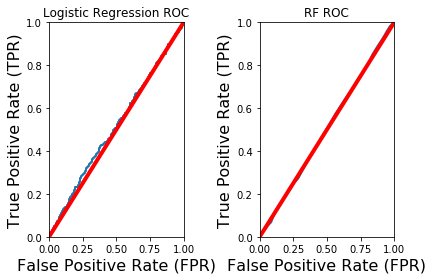

In [38]:
fig = plt.figure()
plt.subplot(121)
plot_roc_curve(lm_false_positive_rate, lm_true_positive_rate)
plt.title('Logistic Regression ROC')

plt.subplot(122)
plot_roc_curve(RFC_false_positive_rate, RFC_true_positive_rate)
plt.title('RF ROC')
plt.tight_layout()

run gridsearch CV

Additional work: <br>
* calculate the returns of DJIA <br>
* try to use kmeans to classify headlines and see how it relates to different classification of return of DJIA <br>
* run gridcv search